# Tarea 4: Generative AI

1. Analiza un GAN o RNN, repasa el ejemplo, haz tu propia copia del cuaderno y haz anotaciones al respecto.
2. Averigua qué hace el código y cómo lo hace (explicando los pasos más importantes).
3. Puede añadir "prints" adicionales si desea mostrar salidas adicionales.
4. Realice uno de los siguientes cambios
- learning rate o el tipo de Optimizador (GANs/RNNs)
- porcentaje del Dropout (GANs/RNNs; normalmente para RNNs hay 2 valores de dropout)
- tamaño de las imágenes (GANs; sólo si el proceso de entrenamiento no dura más de 10 horas)
- rediseñar o añadir una capa (GANs; sólo si el proceso de entrenamiento no dura más de
10 horas)
- tamaño del vocabulario o tamaño de la secuencia utilizada (RNNs; sólo si el proceso de entrenamiento
no dura más de 10 minutos)
- longitud de incrustación (RNN; sólo si el proceso de entrenamiento no dura más de 10
horas)
5. Entrenar y evaluar
6. Explicar el cambio y los nuevos resultados.


# Generación de mi propio texto de Shakespeare


Se tiene una frase dada y se deberá predecir la siguiente palabra, la Red Neuronal Recurrente (RNN) tomará la primera palabra de la frase, esta será pasada por una red neuronal y predecirá la siguiente palabra. Sin embargo, para poder predecir la tercera palabra, toma la activación del estado oculto y la segunda palabra como entrada. El mismo proceso continúa y se capta la relación secuencial porque se utiliza el estado oculto de la palabra anterior para predecir la siguiente, lo que significa que de alguna manera se está utilizando una versión codificada de la frase anterior para predecir la palabra siguiente.

Existen estructuras más eficaces, como las unidades recurrentes controladas (GRU) y las de memoria a largo plazo (LSTM). El problema práctico de por qué se utilizan las GRU y las LSTM en lugar de las RNN es el siguiente: en las RNN, se utiliza la información de cada palabra anterior para predecir correctamente la palabra siguiente, pero a veces una parte de una frase es suficiente para predecir la palabra siguiente en las LSTM y las GRU.

Se utilizará esta idea para diseñar una red de forma que el modelo decida qué palabras seleccionar y escriba como Shakespeare.

# Preprocesamiento

Se creará un dataset que contará con 100 caracteres one-hot encoded como entrada y el output será una versión one-hot encoded del caracter predicho.

## Se importan las librerías

In [ ]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop
from tensorflow.keras.utils import get_file
import numpy as np
import random
import sys
import io
import tensorflow as tf
import matplotlib.pyplot as plt
import platform
import time
import pathlib
import os

Se definen algunas rutas y nombres de archivos relacionados con la descarga y el almacenamiento del conjunto de datos que contiene obras de William Shakespeare.

In [ ]:
# El archivo se almacenará en cache_dir, en la carpeta "tmp"
cache_dir = './tmp'
# Se almacena el nombre del archivo de datos que se descargará, se establece como 'shakespeare.txt'
dataset_file_name = 'shakespeare.txt'
# URL de origen desde la cual se descargará el archivo de datos
dataset_file_origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'

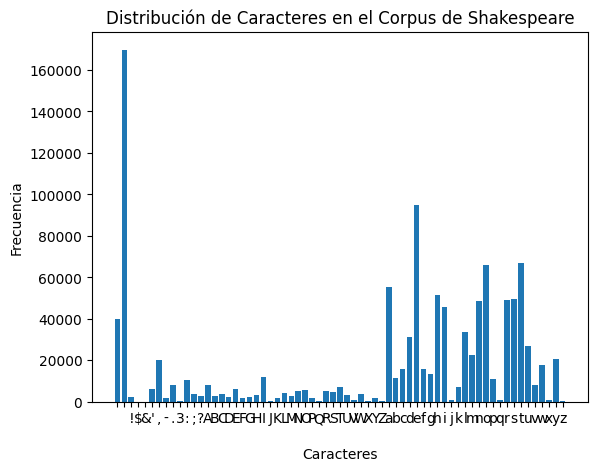

In [ ]:
import matplotlib.pyplot as plt

# Calcular la frecuencia de cada carácter
character_freq = {char: text.count(char) for char in chars}

# Graficar la distribución de caracteres
plt.bar(character_freq.keys(), character_freq.values())
plt.xlabel('Caracteres')
plt.ylabel('Frecuencia')
plt.title('Distribución de Caracteres en el Corpus de Shakespeare')
plt.show()


In [ ]:
'''
Se crea una variable llamada dataset_file_path y se inicializa con el valor
devuelto por la función tf.keras.utils.get_file(). Esta función se utiliza para
descargar un archivo desde una URL y almacenarlo en una ubicación local.
Se descarga el archivo desde la URL de origen especificada y lo almacena en el
directorio de caché con el nombre especificado, y la variable dataset_file_path
contiene la ruta completa del archivo descargado en el sistema de archivos local.
'''
dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=pathlib.Path(cache_dir).absolute()
)


1115394/1115394 [==============================] - 0s 0us/step


In [ ]:
'''
Se abre el archivo de datos descargado, lo lee y lo almacena en una cadena
de texto. Luego, crea diccionarios que relacionan caracteres con índices y
viceversa, lo que es útil para el procesamiento posterior de los datos.
'''

print(dataset_file_path)
ss = open(dataset_file_path,mode='r')
text = ss.read()
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

/tmp/.keras/datasets/shakespeare.txt


In [ ]:
'''
Se crean ejemplos de entrenamiento a partir del texto. Cada ejemplo de
entrenamiento consiste en una secuencia de entrada (X) de longitud Tx y
la secuencia de salida correspondiente (Y) que es el siguiente carácter en el
texto después de la secuencia de entrada.
'''
def build_data(text, Tx = 100, stride = 1):
    X = []
    Y = []
    for i in range(0, len(text) - Tx, stride):
        X.append(text[i: i + Tx])
        Y.append(text[i + Tx])
    print('number of training examples:', len(X))
    return X, Y
X,Y = build_data(text[:10000])

number of training examples: 9900


In [ ]:
'''
Se transforman las secuencias de texto en matrices numéricas binarias
para entrenar un modelo de lenguaje recurrente, donde cada carácter se
representa como un vector one-hot en x, y el siguiente carácter se representa
como un vector one-hot en y.
'''
def vectorization(X, Y, n_x, char_indices, Tx = 100):
    m = len(X)
    x = np.zeros((m, Tx, n_x), dtype=np.bool)
    y = np.zeros((m, n_x), dtype=np.bool)
    for i, sentence in enumerate(X):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
        y[i, char_indices[Y[i]]] = 1
    return x, y

x,y = vectorization(X,Y,len(chars),char_indices,Tx=100)

<ipython-input-6-9ff497dcbf9d>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.zeros((m, Tx, n_x), dtype=np.bool)
<ipython-input-6-9ff497dcbf9d>:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((m, n_x), dtype=np.bool)


In [ ]:
'''
Se introduce aleatoriedad y variabilidad en la generación de texto a partir de
un modelo de lenguaje, lo que puede hacer que el texto  sea más interesante y
diverso. La temperatura controla la cantidad de aleatoriedad en las predicciones

'''
def sample(preds, temperature=0.5):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    out = np.random.choice(range(len(chars)), p = probas.ravel())
    return out

# Desarrollo del modelo

In [ ]:
# Se utiliza LSTM
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(LSTM(256, input_shape=(100, len(chars)),return_sequences=True))
model.add(LSTM(256))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(len(chars), activation='softmax'))
maxlen = 100

def on_epoch_end(epoch, _):
    if epoch > 0 and epoch % 150 == 0:
        print()
        print('----- Generating text after Epoch: %d' % epoch)

        start_index = random.randint(0, len(text) - maxlen - 1)
        for diversity in [0.5]:
            print('----- diversity:', diversity)

            generated = ''
            sentence = text[start_index: start_index + maxlen]
            generated += sentence
            print('----- Generating with seed: "' + sentence + '"')
            sys.stdout.write(generated)

            for i in range(500):
                x_pred = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(sentence):
                    x_pred[0, t, char_indices[char]] = 1.

                preds = model.predict(x_pred, verbose=0)[0]
                next_index = sample(preds, diversity)
                next_char = indices_char[next_index]

                sentence = sentence[1:] + next_char

                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()

        # Guardar el modelo después de cada generación de texto
        model.save('shakespeare_model_after_epoch_{}.h5'.format(epoch))


optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

history = model.fit(x, y,
          batch_size=512,
          epochs=200,
          callbacks=[print_callback])


Epoch 1/200
20/20 [==============================] - 90s 4s/step - loss: 3.6011
Epoch 2/200
20/20 [==============================] - 81s 4s/step - loss: 3.2480
Epoch 3/200
20/20 [==============================] - 80s 4s/step - loss: 3.2314
Epoch 4/200
20/20 [==============================] - 79s 4s/step - loss: 3.2297
Epoch 5/200
20/20 [==============================] - 80s 4s/step - loss: 3.2242
Epoch 6/200
20/20 [==============================] - 80s 4s/step - loss: 3.2219
Epoch 7/200
20/20 [==============================] - 80s 4s/step - loss: 3.1996
Epoch 8/200
20/20 [==============================] - 79s 4s/step - loss: 3.1574
Epoch 9/200
20/20 [==============================] - 79s 4s/step - loss: 3.0693
Epoch 10/200
20/20 [==============================] - 79s 4s/step - loss: 2.9204
Epoch 11/200
20/20 [==============================] - 79s 4s/step - loss: 2.8164
Epoch 12/200
20/20 [==============================] - 80s 4s/step - loss: 2.6606
Epoch 13/200
20/20 [=================

<ipython-input-7-145c20529e7f>:9: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


wor ouf lir,
Ast the thabs is way shat, praties, who dofell sto that aswerca; fake atinous
greins grive, dyo lave ofe hums evou at on this that wate,
One make than poor istucalas, that satino wat patile
And you de? fot yor sandor mating, this all the siven asmer wit, praike with are borksere;
whemise for the comnof this sour than friver, y rise
it wor hame of remaes with be ver hat,
The ires o' tul soffothy wouls, you do for thate,
That inctunte menery, you mrerconp.

MENENIUS:
Either an wh
20/20 [==============================] - 120s 6s/step - loss: 7.0670e-04
Epoch 152/200


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 79s 4s/step - loss: 6.9162e-04
Epoch 153/200
20/20 [==============================] - 79s 4s/step - loss: 6.7664e-04
Epoch 154/200
20/20 [==============================] - 80s 4s/step - loss: 6.6237e-04
Epoch 155/200
20/20 [==============================] - 79s 4s/step - loss: 6.4759e-04
Epoch 156/200
20/20 [==============================] - 79s 4s/step - loss: 6.3413e-04
Epoch 157/200
20/20 [==============================] - 79s 4s/step - loss: 6.2049e-04
Epoch 158/200
20/20 [==============================] - 79s 4s/step - loss: 6.0781e-04
Epoch 159/200
20/20 [==============================] - 79s 4s/step - loss: 5.9513e-04
Epoch 160/200
20/20 [==============================] - 79s 4s/step - loss: 5.8297e-04
Epoch 161/200
20/20 [==============================] - 80s 4s/step - loss: 5.7058e-04
Epoch 162/200
20/20 [==============================] - 80s 4s/step - loss: 5.5918e-04
Epoch 163/200
20/20 [==============================] - 79s 4s/step -

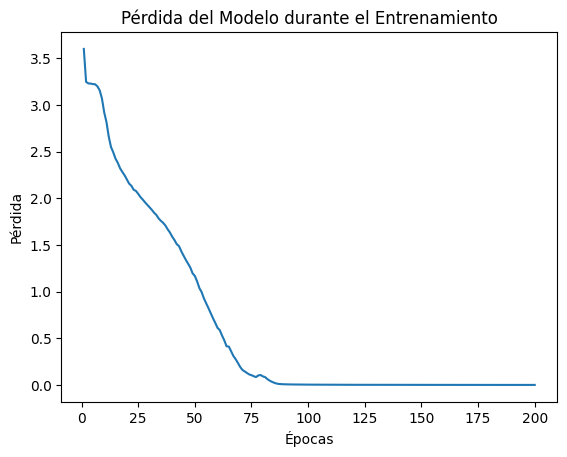

In [ ]:
# Obtener la pérdida del modelo durante el entrenamiento
loss = history.history['loss']

# Graficar la pérdida vs. épocas
plt.plot(range(1, len(loss) + 1), loss)
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida del Modelo durante el Entrenamiento')
plt.show()

In [ ]:
# Mostrar ejemplos de texto generado
for i in range(3):  # Mostrar 3 ejemplos
    seed_text = "To be or not to be, that is the question:"
    generated_text = generate_text(model, seed_text, length=500, diversity=0.5)
    print("Texto Generado", i+1, ":")
    print(generated_text)
    print()

<ipython-input-7-145c20529e7f>:9: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


Texto Generado 1 :
To be or not to be, that is the question:aueailnbillaapvauaolaossrrfi ieeftaoeeooaat;lmtlpavpttvvvtmffdttddftletmlldd; llf plniosal leetdsparlrfapoo rueeaeisivee sffoielmnuflaa folbbvvevss.lillllllaaluoaoiilaaoettvt btpoorttumf fyfuffotmtttalpftoopogmsstfa befoamomt;yfnaulaetttooiebati;ds;aluiepeaaliplttaal'boomrtsrr f afflrale orttoaaovstflematmeptoetssac;aoaioeeyaesronaeefra otoaflac; fot;afa le etvmfvlpvtortermurrlle lsovibappttllleempo oertaolsla etylifoobsaollaeeuummmttamfsapsettlt sf;apftaayay'oubrr aftt oleeoeesfdaaenb apimaaetl

Texto Generado 2 :
To be or not to be, that is the question:vbvlllf   mftdtsploupiepelpioobetoayatai;mfmieealeafoflolpodntade?llaeaivooo'e,mta?eaaailetllpssrtvoaes rrtllmpeeeeee rflfaiaaau'flnaaoee ef t  vpvmllpasrmtmaaesfaaaoablaaaiuueeaytyfy s'fioaooodt fiillssol dtstda rlmmpllttlpffflllllpooeraepbtvvneaplfsalvtmtttyvavmmit rmptpellll oiaaaa uotl aoetttrfoiiyaanoya aiedt vpplvaasafytcrl t rlmttaaasseoreosffltolieepatftfttaaosrsoiett

Se puede observar que el texto generado no tiene ningún sentido o coherencia. Esto puede deberse a el tamaño del modelo, la cantidad de datos de entrenamiento, la diversidad y otros hiperparámetros. En este caso, el texto puede no ser coherente ni representar una continuación lógica de la frase inicial debido a lo difícil que puede ser generar un texto que imite el estilo de Shakespeare.

Aunque se cambió el optimizador no se vieron resultados que parezcan mejores, puede ser que mejore cambiando el learning rate aparte del optimizador. Debo seguir haciendo cambios para ver qué puede hacer que mejore el modelo.